In [1]:
# Preprocessing data from bigquery with pandas using pandas-gbq library

In [2]:
# venv_dev
"""
python3 -m venv venv_dev
source venv_dev/bin/activate
pip install ipykernel
pip install google-cloud-bigquery 
pip install google-cloud-storage
pip install pandas
pip install pyarrow
pip install pandas-gbq
pip install tqdm
pip install matplotlib
"""

'\npython3 -m venv venv_dev\nsource venv_dev/bin/activate\npip install ipykernel\npip install google-cloud-bigquery \npip install google-cloud-storage\npip install pandas\npip install pyarrow\npip install pandas-gbq\npip install tqdm\npip install matplotlib\n'

In [3]:
import pandas as pd
import pandas_gbq
import os
from IPython.display import display
from google.cloud import bigquery

In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "key-vlille-gcp-etl.json"

In [5]:
client = bigquery.Client()

In [6]:
PROJECT_ID="vlille-gcp-etl"
DATASET_NAME="vlille_ml_test"

In [6]:
query = f"""
SELECT
    *
FROM
    `{DATASET_NAME}.stations`
ORDER BY
    id
"""


df = pandas_gbq.read_gbq(query, project_id=PROJECT_ID, location='us')
display(df.head())

Downloading: 100%|██████████|


,id,name,adress,city,type,latitude,longitude
0,1,METROPOLE EUROPEENNE DE LILLE,MEL RUE DU BALLON,LILLE,AVEC TPE,50.641926,3.075992
1,2,UNIVERSITE CATHOLIQUE,RUE DU PORT BD VAUBAN,LILLE,AVEC TPE,50.632233,3.046134
2,3,JARDIN VAUBAN,39 BOULEVARD VAUBAN,LILLE,AVEC TPE,50.636093,3.050447
3,4,MAISON FOLIE WAZEMMES,28 RUE DE L'HOPITAL SAINT ROCH,LILLE,AVEC TPE,50.624695,3.048961
4,5,MASSENA,73 RUE MASSENA,LILLE,AVEC TPE,50.631560,3.054738


In [7]:
query = f"""
SELECT
    *
FROM
    `{DATASET_NAME}.records`
    LIMIT 10
"""

df = pandas_gbq.read_gbq(query, project_id=PROJECT_ID)
display(df)

Downloading: 100%|██████████|


,station_id,etat,nb_velos_dispo,nb_places_dispo,etat_connexion,derniere_maj,record_timestamp,rn
0,<NA>,None,<NA>,<NA>,None,NaT,2023-09-09 01:04:03.068000+00:00,1
1,<NA>,None,<NA>,<NA>,None,NaT,2023-10-01 00:29:00.944000+00:00,1
2,<NA>,None,<NA>,<NA>,None,NaT,2023-09-08 08:39:01.213000+00:00,1
3,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2024-01-11 00:34:01.093000+00:00,1
4,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2023-10-15 01:40:01.386000+00:00,1
5,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2024-01-10 18:57:01.180000+00:00,1
6,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2023-10-13 11:54:01.561000+00:00,1
7,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2023-10-18 08:37:00.932000+00:00,1
8,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2023-10-29 18:37:01.107000+00:00,1
9,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2023-11-13 07:04:01.463000+00:00,1


In [9]:
# copy the record table with bigquery client to another table named records_copy
table_id = f"{PROJECT_ID}.{DATASET_NAME}.records"
table_id_copy = f"{PROJECT_ID}.{DATASET_NAME}.records_copy"

job = client.copy_table(table_id, table_id_copy)
job.result()  # Wait for the job to complete.

print(f"Table {table_id} copied to {table_id_copy}.")

Table vlille-gcp-etl.vlille_ml_test.records copied to vlille-gcp-etl.vlille_ml_test.records_copy.


In [8]:
# get the number of rows in the records_copy table
query = f"""
SELECT
    COUNT(*) as nb_rows
FROM
    `{DATASET_NAME}.records_copy`
"""

df = pandas_gbq.read_gbq(query, project_id=PROJECT_ID)
display(df)

Downloading: 100%|██████████|


,nb_rows
0,66801099


In [11]:
query = f"""
SELECT
    r.*
FROM
    `{DATASET_NAME}.records_copy` r
JOIN
    (
        SELECT
            station_id,
            MAX(record_timestamp) as max_timestamp
        FROM
            `{DATASET_NAME}.records_copy`
        GROUP BY
            station_id
    ) subq
ON
    r.station_id = subq.station_id AND
    r.record_timestamp = subq.max_timestamp
LIMIT 10
"""

df = pandas_gbq.read_gbq(query, project_id=PROJECT_ID)
display(df)

Downloading: 100%|██████████|


,station_id,etat,nb_velos_dispo,nb_places_dispo,etat_connexion,derniere_maj,record_timestamp,rn
0,60,EN SERVICE,16,4,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
1,257,EN SERVICE,7,8,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
2,239,EN SERVICE,5,8,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
3,167,EN SERVICE,7,13,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
4,18,EN SERVICE,13,1,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
5,56,EN SERVICE,8,10,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
6,190,EN SERVICE,2,12,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
7,273,EN SERVICE,7,13,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
8,262,RÉFORMÉ,0,1,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2024-02-06 19:50:02.807000+00:00,1
9,20,EN SERVICE,23,7,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1


In [26]:
# query to get the number of available places for the station_id = 25, ordered by distinct record_timestamp
query = f"""
SELECT
    station_id, 
    etat,
    nb_velos_dispo,
    nb_places_dispo,
    etat_connexion,
    derniere_maj,
    record_timestamp
FROM
    `{DATASET_NAME}.records_copy`
WHERE 
  station_id = 25
  AND record_timestamp >= '2024-01-23'
  AND record_timestamp <= '2024-01-25'
ORDER BY record_timestamp DESC
"""

df = pandas_gbq.read_gbq(query, project_id=PROJECT_ID)
display(df.head())

Downloading: 100%|██████████|


,station_id,etat,nb_velos_dispo,nb_places_dispo,etat_connexion,derniere_maj,record_timestamp
0,25,EN SERVICE,1,30,CONNECTÉ,2024-01-24 23:57:11+00:00,2024-01-24 23:59:00.481000+00:00
1,25,EN SERVICE,1,30,CONNECTÉ,2024-01-24 23:56:11+00:00,2024-01-24 23:58:02.628000+00:00
2,25,EN SERVICE,1,30,CONNECTÉ,2024-01-24 23:55:11+00:00,2024-01-24 23:57:02.848000+00:00
3,25,EN SERVICE,1,30,CONNECTÉ,2024-01-24 23:54:10+00:00,2024-01-24 23:56:01.127000+00:00
4,25,EN SERVICE,1,30,CONNECTÉ,2024-01-24 23:53:11+00:00,2024-01-24 23:55:00.755000+00:00


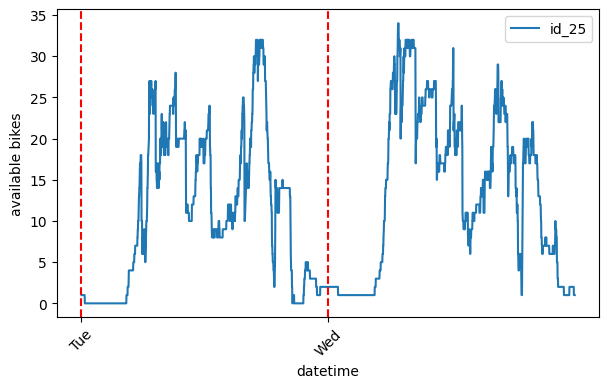

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert record_timestamp to datetime
df['record_timestamp'] = pd.to_datetime(df['record_timestamp'])

# Sort dataframe by record_timestamp
df.sort_values('record_timestamp', inplace=True)

# Filter data for each station
df_id25 = df[df['station_id'] == 25]

# Plotting
plt.figure(figsize=(7,4))

# Plot for LIL0003
plt.plot(df_id25['record_timestamp'], df_id25['nb_velos_dispo'], label='id_25')


# Generate midnight times
midnights = pd.date_range(start=df['record_timestamp'].min(), end=df['record_timestamp'].max(), freq='D', normalize=True)

# Add vertical lines at each midnight
for midnight in midnights:
    plt.axvline(x=midnight, color='r', linestyle='--')
    
# Set x-axis tick labels
plt.xticks(midnights, [midnight.strftime("%A")[:3] for midnight in midnights], rotation=45)


plt.xlabel('datetime')
plt.ylabel('available bikes')
plt.legend()
plt.show()